## Imports

In [1]:
from skimage.io import imread
from skimage.filters import gaussian
import numpy as np
from matplotlib import pyplot as plt
from skimage import img_as_float
import math

# Function to compute the moments of the image

In [2]:
from numpy import mgrid, sum


def similitudeMoments(image):
    
    ### Make sure the image is a grayscale image
    assert len(image.shape) == 2
    
    ## Temp grid for storing intermediate operations
    x, y = mgrid[:image.shape[0],:image.shape[1]]
    
    ## Our final dictionary that contains the 
    moments = {}
    
    
    moments['mean_x'] = sum(x*image)/sum(image)
    moments['mean_y'] = sum(y*image)/sum(image)
    
    ## Spatial moments: Spatial moments  often used to describe region shape
    
    # Zeroth Order
    moments['m00'] = sum(image)
    
    # First Order
    moments['m01'] = sum(x*image)
    moments['m10'] = sum(y*image)
    
    # Second Order
    moments['m11'] = sum(y*x*image)
    moments['m02'] = sum(x**2*image)
    moments['m20'] = sum(y**2*image)
    
    # Third Order
    moments['m12'] = sum(x*y**2*image)
    moments['m21'] = sum(x**2*y*image)
    moments['m03'] = sum(x**3*image)
    moments['m30'] = sum(y**3*image)
    
    ## Central moments: Translation Invariant
    
    # First Order (Seem useless, in terms of calculating the final nu moments. But still kept)
    moments['mu01']= sum((y-moments['mean_y'])*image)
    moments['mu10']= sum((x-moments['mean_x'])*image)
    
    # Second Order (Moment Ellipse Orientation)
    moments['mu11'] = sum((x-moments['mean_x'])*(y-moments['mean_y'])*image)
    moments['mu02'] = sum((y-moments['mean_y'])**2*image)
    moments['mu20'] = sum((x-moments['mean_x'])**2*image)
    
    # Third Order (Skewness of the Image)
    moments['mu12'] = sum((x-moments['mean_x'])*(y-moments['mean_y'])**2*image)
    moments['mu21'] = sum((x-moments['mean_x'])**2*(y-moments['mean_y'])*image)
    moments['mu03'] = sum((y-moments['mean_y'])**3*image)
    moments['mu30'] = sum((x-moments['mean_x'])**3*image)
    
    # Similitude Moments: Invariant to translation and scale
    
    moments['eta11'] = moments['mu11'] / sum(image)**(2/2+1)
    moments['eta12'] = moments['mu12'] / sum(image)**(3/2+1)
    moments['eta21'] = moments['mu21'] / sum(image)**(3/2+1)
    moments['eta02'] = moments['mu02'] / sum(image)**(2/2+1)
    moments['eta20'] = moments['mu20'] / sum(image)**(2/2+1)
    moments['eta03'] = moments['mu03'] / sum(image)**(3/2+1)
    moments['eta30'] = moments['mu30'] / sum(image)**(3/2+1)
    
    return moments

In [3]:
image_cube = []

for i in range(1,5):
    tmp = imread(f'./data/boxIm{i}.bmp')
    tmp = img_as_float(tmp)
    image_cube.append(tmp)

In [4]:
tmom = similitudeMoments(image_cube[1])
tmom

{'eta02': 0.1646090534979424,
 'eta03': 0.0,
 'eta11': 0.0,
 'eta12': 0.0,
 'eta20': 0.04215597711532671,
 'eta21': 0.0,
 'eta30': 0.0,
 'm00': 3321.0,
 'm01': 129519.0,
 'm02': 5516181.0,
 'm03': 251396379.0,
 'm10': 195939.0,
 'm11': 7641621.0,
 'm12': 521659359.0,
 'm20': 13375881.0,
 'm21': 325454679.0,
 'm30': 1003403619.0,
 'mean_x': 39.0,
 'mean_y': 59.0,
 'mu01': 0.0,
 'mu02': 1815480.0,
 'mu03': 0.0,
 'mu10': 0.0,
 'mu11': 0.0,
 'mu12': 0.0,
 'mu20': 464940.0,
 'mu21': 0.0,
 'mu30': 0.0}

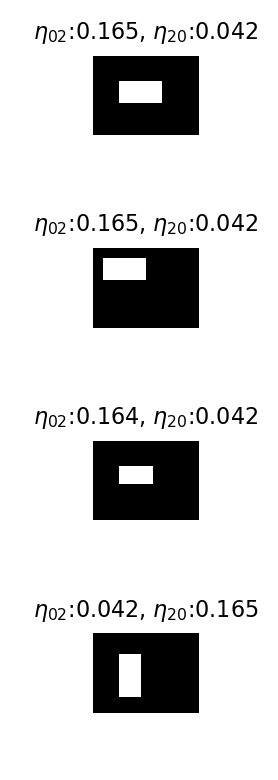

In [5]:
f, axarr = plt.subplots(4,1, sharey='row', dpi=200)
s1= "$\eta_{02}$"
s2 = "$\eta_{20}$"
for i in range(4):
    tmom = similitudeMoments(image_cube[i])
    axarr[i].imshow(image_cube[i], cmap='gray')
    axarr[i].axis('off')
    axarr[i].set_title(f"{s1}:{round(tmom['eta02'],3)}, {s2}:{round(tmom['eta20'],3)}", fontsize=8)
plt.tight_layout()

(The other moments were also calculated, but were ignored since they amount to 0).

From the above plot it is clear that the rectangles only have $\eta_{02}$ and $\eta_{20}$ values. This is because of their perfect symmetry, and "squarish" nature that they do not exhibit most other properties other than the orientation, which is given by the aforementioned second order moments.

Note that for the 1 rectangle thats oriented transposed of the others, the values swap, thus telling us that the orientation has itself transposed.

# Load up eigdata.txt and perform background-subtraction

In [6]:
X = np.loadtxt('./data/eigdata.txt')

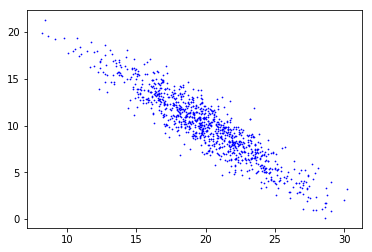

In [7]:
plt.scatter(X[:,0],X[:,1], s=0.5, c='blue')

In [8]:
m = np.mean(X, axis=0)

Y = X - m

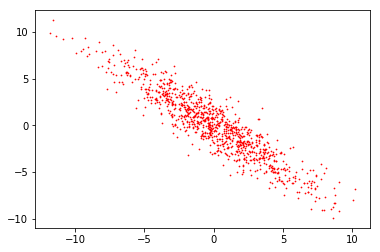

In [9]:
plt.scatter(Y[:,0],Y[:,1], s=0.5, c='red')

# Compute Eigenvalues and Eigenvectors of the data

First we calculate the covariance matrix

In [10]:
covariance = np.cov(Y.T)

covariance.shape

(2, 2)

Now we calculate the eigenvalues and eigenvectors from the covariance matrix (`Note: We are not using np.linalg.inv(covariance)`) This would mean that the upcoming steps will have a slight difference.

In [11]:
[w, v] = np.linalg.eig(covariance)
largest_eigvec = v[0]
smallest_eigvec = v[1]

Calculating the angle between x-axis and the largest eigenvector, since we will aim to project our data onto that axis. We also need to ensure that this angle is between $[0,2\pi]$, though our `arctan2` gives us the angle in $[-\pi,\pi]$. Hence we shift it by $2\pi$ if negative.

In [12]:
angle = np.arctan2(largest_eigvec[1], largest_eigvec[0])
if angle < 0:
    angle = angle + 2*np.pi

Co-ordinates of our data mean, basically so that we can center our plots, no real function in terms of our projection and de-correlation.

In [13]:
avg = np.mean(Y, axis=0)

The $3\sigma$ std-deviation corresponds to `0.9973` in terms of confidence interval, and our corresponding $\chi^2$ value then becomes `7.378`. If we have to center our ellipse around this, we take sq, root since each $\sigma_x$ and $\sigma_y$ requires this parameter.

In [14]:
chisquare_val = np.sqrt(7.378)
theta_grid = np.linspace(0, 2*np.pi)
phi = -angle
X0 = avg[0]
Y0 = avg[1]

Generating a gridspace for our ellipse

In [15]:
a=chisquare_val*np.sqrt(w[0])
b=chisquare_val*np.sqrt(w[1])

ellipse_x_r  = a*np.cos( theta_grid )
ellipse_y_r  = b*np.sin( theta_grid )

Rotation matrix for our ellipse, so that it corresponds to our data

In [16]:
R = np.array([[ np.cos(phi), np.sin(phi)], [-np.sin(phi), np.cos(phi)]]).reshape((2,2))

c:\users\theanig\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


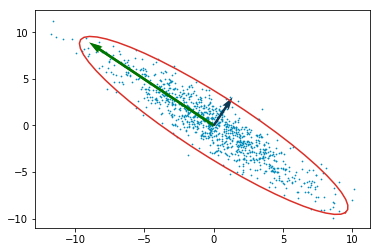

In [17]:
r_ellipse = np.vstack((ellipse_x_r, ellipse_y_r)).T @ R

plt.plot(r_ellipse[:,0] + X0,r_ellipse[:,1] + Y0, c='#db2f27')
plt.scatter(Y[:,0],Y[:,1], s=0.5, c='#008cbc')
plt.quiver(0, 0, -1.5*np.sqrt(largest_eigvec), 1*np.sqrt(largest_eigvec), color='#007500', scale=3.4)
plt.quiver(0, 0, 1*np.sqrt(smallest_eigvec), 1.5*np.sqrt(smallest_eigvec), color='#0b3954', scale=15)

In the above plot we can see ellipse at $3\sigma$ around the data, along with the two principal axes, given by the eigenvectors.

# Make the data un-correlated

In order to de-correlate the data, we rotate the given data about its axes such that it aligns with our largest eigenvector.

In [18]:
stddev = np.sqrt(np.diag(covariance))

c:\users\theanig\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


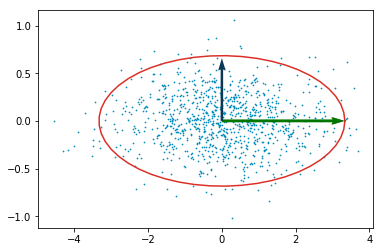

In [19]:
decorrelated_y = np.divide(Y, stddev)
decorrelated_y = decorrelated_y @ v

plt.plot(ellipse_x_r/4, ellipse_y_r/4, c='#db2f27')
plt.scatter(decorrelated_y[:,0],decorrelated_y[:,1], s=0.5, c='#008cbc')
plt.quiver(0, 0, 1*np.sqrt(largest_eigvec), 0*np.sqrt(largest_eigvec), color='#007500', scale=2.3)
plt.quiver(0, 0, 0*np.sqrt(smallest_eigvec), 1*np.sqrt(smallest_eigvec), color='#0b3954', scale=4.5)

Note that in the above figure, our squished ellipse from previous question appears to have fattened a little bit, this is merely an illusion generated due to use of different scaling along the other axis (done explicitly by me to make the results look better), if we were to measure the thickness empirically, we would find the two results to be the same.

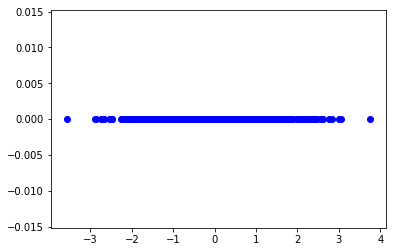

In [20]:
projected_y = Y @ largest_eigvec.T
plt.scatter(projected_y, np.zeros_like(projected_y), c='blue')

Now we project the data down to 1D along the largest eigenvector. Note that in this particular case, there was some information spread about the other axis, which was lost, but not significant enough that we are unable to utilize the results.

At such a low dimension, PCA performs just as good as any, but if the given data were of higher dimensionality, we could've had some interesting comparision with more sophisticated dimensionality reduction algorithms like t-SNE and compared the two.